In [46]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [2]:
df=pd.read_csv("lyrics-data.csv")
df_genres = pd.read_csv("artists-genres.csv")
df

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [3]:
df.describe()

,ALink,SName,SLink,Lyric,language
count,379930,379928,379930,379854,365296
unique,4238,267258,379892,371181,52
top,/anjos-anonimos/,Intro,/joan-baez/aint-gonna-let-nobody-turn-me-aroun...,Instrumental,en
freq,1029,116,2,2087,191814


In [4]:
df.ALink.value_counts()

/anjos-anonimos/            1029
/carlos-santorelli/          903
/frank-sinatra/              828
/matheus-hardke/             797
/marchinhas-de-carnaval/     782
                            ... 
/cl-a-posse/                   1
/ukulele-das-americas/         1
/clara-fallandes/              1
/the-sopranos/                 1
/avoure/                       1
Name: ALink, Length: 4238, dtype: int64

In [5]:
df.language.value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

In [6]:
df = df[df['language'] == 'en']

In [7]:
df.describe()

,ALink,SName,SLink,Lyric,language
count,191814,191812,191814,191814,191814
unique,2508,138182,191793,189394,1
top,/frank-sinatra/,Home,/nat-king-cole/i-love-you-for-sentimental-reas...,Shortcut to part of Bill Monroe Lyrics\nBill M...,en
freq,819,93,2,41,191814


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191814 entries, 69 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     191814 non-null  object
 1   SName     191812 non-null  object
 2   SLink     191814 non-null  object
 3   Lyric     191814 non-null  object
 4   language  191814 non-null  object
dtypes: object(5)
memory usage: 8.8+ MB


In [9]:
df_genres.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [10]:
df_genres.rename(columns={'Link': 'ALink'}, inplace=True)

In [11]:
df = df.merge(df_genres[["ALink","Genres", "Popularity"]], on="ALink", how="left")

In [12]:
df['Genres'].str.split(';', expand=True)

,0,1,2,3
0,Pop,Axé,Romântico,None
1,Pop,Axé,Romântico,None
2,Pop,Axé,Romântico,None
3,Pop,Axé,Romântico,None
4,Pop,Axé,Romântico,None
...,...,...,...,...
191809,World Music,Gospel/Religioso,None,None
191810,World Music,Gospel/Religioso,None,None
191811,World Music,Gospel/Religioso,None,None
191812,World Music,Gospel/Religioso,None,None


In [13]:
df[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4']] = df['Genres'].str.split(';', expand=True)

In [14]:
df

,ALink,SName,SLink,Lyric,language,Genres,Popularity,Genre 1,Genre 2,Genre 3,Genre 4
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,Pop; Axé; Romântico,4.4,Pop,Axé,Romântico,None
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,Pop; Axé; Romântico,4.4,Pop,Axé,Romântico,None
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,Pop; Axé; Romântico,4.4,Pop,Axé,Romântico,None
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,Pop; Axé; Romântico,4.4,Pop,Axé,Romântico,None
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,Pop; Axé; Romântico,4.4,Pop,Axé,Romântico,None
...,...,...,...,...,...,...,...,...,...,...,...
191809,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en,World Music; Gospel/Religioso,0.0,World Music,Gospel/Religioso,None,None
191810,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en,World Music; Gospel/Religioso,0.0,World Music,Gospel/Religioso,None,None
191811,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en,World Music; Gospel/Religioso,0.0,World Music,Gospel/Religioso,None,None
191812,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en,World Music; Gospel/Religioso,0.0,World Music,Gospel/Religioso,None,None


In [15]:
df = df.drop(columns=['Genres'])

In [16]:
df

,ALink,SName,SLink,Lyric,language,Popularity,Genre 1,Genre 2,Genre 3,Genre 4
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,4.4,Pop,Axé,Romântico,None
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,4.4,Pop,Axé,Romântico,None
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,4.4,Pop,Axé,Romântico,None
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,4.4,Pop,Axé,Romântico,None
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,4.4,Pop,Axé,Romântico,None
...,...,...,...,...,...,...,...,...,...,...
191809,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en,0.0,World Music,Gospel/Religioso,None,None
191810,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en,0.0,World Music,Gospel/Religioso,None,None
191811,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en,0.0,World Music,Gospel/Religioso,None,None
191812,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en,0.0,World Music,Gospel/Religioso,None,None


In [26]:
df.describe()

,Popularity,Number_of_words
count,63717.00000,63717.000000
mean,5.13212,206.810788
std,10.68297,100.554082
min,0.00000,2.000000
25%,0.00000,141.000000
50%,1.00000,193.000000
75%,4.50000,255.000000
max,67.50000,3300.000000


In [31]:
df = df[df.Popularity > 60]

In [32]:
df[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4']].apply(pd.Series.value_counts)

,Genre 1,Genre 2,Genre 3,Genre 4
Indie,NaN,NaN,130.0,NaN
Pop,166.0,NaN,NaN,NaN
Pop/Rock,NaN,NaN,483.0,NaN
Psicodelia,NaN,317.0,NaN,NaN
Rock,447.0,166.0,NaN,NaN
Rock Alternativo,NaN,130.0,NaN,NaN


In [33]:
for col in df.columns:
    display(df[col].value_counts().head(10))

/the-beatles/        317
/maroon-5/           166
/imagine-dragons/    130
Name: ALink, dtype: int64

Wait                          2
All My Loving                 2
If I Fell                     2
Misery                        2
Ticket To Ride                2
Yesterday                     2
Here, There And Everywhere    1
Hello Little Girl             1
Hello, Little Girl            1
Helter Skelter                1
Name: SName, dtype: int64

/imagine-dragons/believer.html                 1
/the-beatles/hippy-hippy-shake.html            1
/the-beatles/have-a-banana-speech.html         1
/the-beatles/hello-little-girl-2.html          1
/the-beatles/hello-little-girl.html            1
/the-beatles/helter-skelter.html               1
/the-beatles/her-majesty.html                  1
/the-beatles/here-there-and-everywhere.html    1
/the-beatles/hey-bulldog.html                  1
/the-beatles/hold-me-tight.html                1
Name: SLink, dtype: int64

(instrumental track)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

en    613
Name: language, dtype: int64

64.2    317
64.0    166
67.5    130
Name: Popularity, dtype: int64

Rock    447
Pop     166
Name: Genre 1, dtype: int64

Psicodelia          317
Rock                166
Rock Alternativo    130
Name: Genre 2, dtype: int64

Pop/Rock    483
Indie       130
Name: Genre 3, dtype: int64

Series([], Name: Genre 4, dtype: int64)

207    8
181    7
152    7
204    6
148    6
176    6
230    5
175    5
132    5
165    5
Name: Number_of_words, dtype: int64

In [34]:
df['Genre 1'] = df['Genre 1'].str.strip()
df['Genre 2'] = df['Genre 2'].str.strip()
df['Genre 3'] = df['Genre 3'].str.strip()
df['Genre 4'] = df['Genre 4'].str.strip()

C:\Users\jorpe\AppData\Local\Temp/ipykernel_5504/3501131947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre 1'] = df['Genre 1'].str.strip()
C:\Users\jorpe\AppData\Local\Temp/ipykernel_5504/3501131947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre 2'] = df['Genre 2'].str.strip()
C:\Users\jorpe\AppData\Local\Temp/ipykernel_5504/3501131947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [35]:
from collections import Counter

df_genres = df[['Genre 1','Genre 2','Genre 3', 'Genre 4']]

final_count = Counter()
for col in df_genres.columns:
    final_count = Counter(df_genres[col]) + final_count

print(final_count)

Counter({None: 613, 'Rock': 613, 'Pop/Rock': 483, 'Psicodelia': 317, 'Pop': 166, 'Indie': 130, 'Rock Alternativo': 130})


In [36]:
df = df[(df['Genre 1'] == 'Rock') | (df['Genre 2'] == 'Rock') | (df['Genre 3'] == 'Rock') | (df['Genre 4'] == 'Rock')]

In [37]:
df

,ALink,SName,SLink,Lyric,language,Popularity,Genre 1,Genre 2,Genre 3,Genre 4,Number_of_words
103971,/imagine-dragons/,Believer,/imagine-dragons/believer.html,First things first\nI'ma say all the words ins...,en,67.5,Rock,Rock Alternativo,Indie,None,406
103972,/imagine-dragons/,Bones,/imagine-dragons/bones.html,"Gimme, gimme, gimme some time to think\nI'm in...",en,67.5,Rock,Rock Alternativo,Indie,None,316
103973,/imagine-dragons/,Enemy (With J.I.D),/imagine-dragons/enemy-with-j-i-d.html,(Look out for yourself)\n\nI wake up to the so...,en,67.5,Rock,Rock Alternativo,Indie,None,417
103974,/imagine-dragons/,Wrecked,/imagine-dragons/wrecked.html,Days pass by and my eyes they dry\nAnd I think...,en,67.5,Rock,Rock Alternativo,Indie,None,448
103975,/imagine-dragons/,Demons,/imagine-dragons/demons.html,When the days are cold\nAnd the cards all fold...,en,67.5,Rock,Rock Alternativo,Indie,None,310
...,...,...,...,...,...,...,...,...,...,...,...
155034,/the-beatles/,You'll Be Mine,/the-beatles/youll-be-mine.html,Well darling all the night\nYou'll be mine and...,en,64.2,Rock,Psicodelia,Pop/Rock,None,98
155035,/the-beatles/,You're Going To Lose That Girl,/the-beatles/youre-going-to-lose-that-girl.html,You're gonna lose that girl.\nYou're gonna los...,en,64.2,Rock,Psicodelia,Pop/Rock,None,195
155036,/the-beatles/,You've Got to Hide Your Love Away,/the-beatles/youve-got-to-hide-your-love-away....,Here I stand head in hand\nTurn my face to the...,en,64.2,Rock,Psicodelia,Pop/Rock,None,104
155037,/the-beatles/,Young Blood,/the-beatles/young-blood.html,I saw her standing on the corner\nA yellow rib...,en,64.2,Rock,Psicodelia,Pop/Rock,None,189


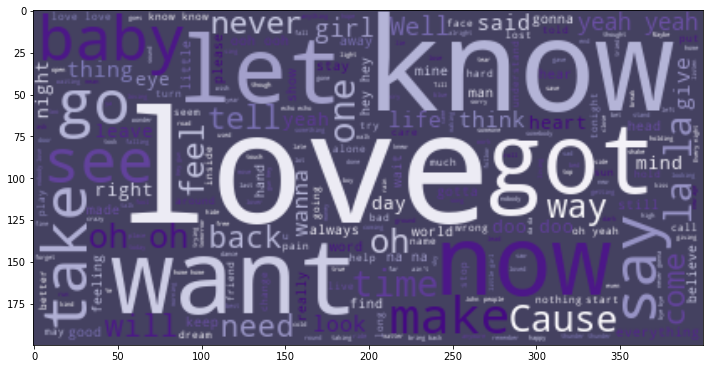

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(df["Lyric"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [39]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,ALink,SName,SLink,Lyric,language,Popularity,Genre 1,Genre 2,Genre 3,Genre 4,Number_of_words
103971,/imagine-dragons/,Believer,/imagine-dragons/believer.html,First things first\nI'ma say all the words ins...,en,67.5,Rock,Rock Alternativo,Indie,None,406
103972,/imagine-dragons/,Bones,/imagine-dragons/bones.html,"Gimme, gimme, gimme some time to think\nI'm in...",en,67.5,Rock,Rock Alternativo,Indie,None,316
103973,/imagine-dragons/,Enemy (With J.I.D),/imagine-dragons/enemy-with-j-i-d.html,(Look out for yourself)\n\nI wake up to the so...,en,67.5,Rock,Rock Alternativo,Indie,None,417
103974,/imagine-dragons/,Wrecked,/imagine-dragons/wrecked.html,Days pass by and my eyes they dry\nAnd I think...,en,67.5,Rock,Rock Alternativo,Indie,None,448
103975,/imagine-dragons/,Demons,/imagine-dragons/demons.html,When the days are cold\nAnd the cards all fold...,en,67.5,Rock,Rock Alternativo,Indie,None,310


In [40]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

[454,
 114,
 454,
 1529,
 58,
 18,
 3,
 282,
 176,
 8,
 161,
 10,
 2130,
 32,
 6,
 535,
 20,
 3,
 65,
 11,
 114,
 76,
 78,
 13,
 62,
 3,
 65,
 11,
 114,
 76,
 78,
 13,
 62,
 408,
 178,
 408,
 17,
 1,
 80,
 5,
 39,
 1,
 103,
 11,
 2,
 105,
 15,
 10,
 3,
 52,
 79,
 3,
 1530,
 10,
 3,
 1282,
 20,
 8,
 481,
 13,
 62,
 3,
 1282,
 20,
 8,
 481,
 13,
 62,
 2,
 55,
 373,
 73,
 7,
 243,
 334,
 252,
 8,
 2530,
 4,
 3,
 1852,
 1138,
 8,
 2131,
 24,
 3,
 820,
 11,
 618,
 79,
 5,
 308,
 4,
 5,
 1531,
 4,
 5,
 185,
 5,
 496,
 73,
 1283,
 73,
 3,
 173,
 67,
 32,
 8,
 1003,
 73,
 3,
 840,
 1072,
 8,
 1853,
 73,
 3,
 1394,
 636,
 3,
 1284,
 127,
 3,
 173,
 1,
 154,
 5,
 7,
 1,
 154,
 5,
 7,
 354,
 354,
 173,
 1,
 274,
 5,
 50,
 1,
 752,
 5,
 32,
 354,
 354,
 173,
 2,
 53,
 3,
 1139,
 348,
 13,
 53,
 201,
 256,
 8,
 85,
 8,
 14,
 8,
 570,
 96,
 238,
 73,
 173,
 1,
 154,
 5,
 7,
 1,
 154,
 5,
 7,
 354,
 354,
 1195,
 114,
 1195,
 450,
 7,
 2132,
 4,
 3,
 363,
 32,
 512,
 18,
 3,
 704,
 11,
 165,
 382,
 24

In [41]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [43]:
import tensorflow as tf
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [56]:
# create model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

Epoch 1/5
4532/4532 [==============================] - 2014s 443ms/step - loss: 5.8420 - accuracy: 0.0655
Epoch 2/5
4532/4532 [==============================] - 2053s 453ms/step - loss: 5.1506 - accuracy: 0.1243
Epoch 3/5
4532/4532 [==============================] - 1999s 441ms/step - loss: 4.7403 - accuracy: 0.1643
Epoch 4/5
4532/4532 [==============================] - 1966s 434ms/step - loss: 4.4302 - accuracy: 0.1979
Epoch 5/5
4532/4532 [==============================] - 2126s 469ms/step - loss: 4.1859 - accuracy: 0.2266
